In [3]:
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull
import datetime
import json
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import textwrap

In [27]:
conversation_dfs = []
with open("skype_messages.json", encoding="utf-8") as sj:
    sdict = json.load(sj)
    # print(sdict["conversations"][0])
    for c in sdict["conversations"]:
        df = pd.DataFrame( c["MessageList"])
        conversation_dfs.append(df)

all_df = pd.concat(conversation_dfs)
all_df["datetime"] = all_df.originalarrivaltime.apply(lambda dts: pd.Timestamp(dts)) 
all_df["message_length"] = all_df.content.apply(lambda c: len(c)) 
all_df["machine_message"] = all_df.content.apply(lambda c: c[0]in["<","{", "["] if len(c) else True) 

all_df = all_df.set_index("datetime")
all_df.sample(10)

,id,displayName,originalarrivaltime,messagetype,version,content,conversationid,from,properties,amsreferences,message_length,machine_message
datetime,,,,,,,,,,,,
2017-07-16 21:03:23.208000+00:00,1500239003310,Charles Ogilvie,2017-07-16T21:03:23.208Z,Event/Call,1.500239e+12,"<partlist type=""started"" alt="""">\n <part iden...",8:charles.ogilvie,8:charles.ogilvie,None,None,187,True
2018-01-09 17:12:29.160000+00:00,1515517950008,Charles Ogilvie,2018-01-09T17:12:29.16Z,Event/Call,1.515518e+12,"<partlist type=""missed"" alt=""""><part identity=...",8:charles.ogilvie,8:charles.ogilvie,None,None,148,True
2017-05-07 20:08:04.402000+00:00,1494187684437,Charles Ogilvie,2017-05-07T20:08:04.402Z,Text,1.494188e+12,yo,8:charles.ogilvie,8:charles.ogilvie,None,None,2,False
2017-05-07 20:18:18.551000+00:00,1494188298553,Charles Ogilvie,2017-05-07T20:18:18.551Z,Event/Call,1.494188e+12,"<partlist type=""started"" alt=""""><part identity...",19:1b1a7f9eec27473382ec74cdf411888a@thread.skype,8:charles.ogilvie,None,None,111,True
2018-01-30 20:34:19.782000+00:00,1517344460723,None,2018-01-30T20:34:19.782Z,RichText,1.517344e+12,Good to go when you are,8:rw.at.sfu.ca,8:notionparallax,None,None,23,False
2017-05-10 20:09:46.887000+00:00,1494446986880,Charles Ogilvie,2017-05-10T20:09:46.887Z,Text,1.494447e+12,hi d00d,8:charles.ogilvie,8:charles.ogilvie,None,None,7,False
2018-04-28 09:16:54.394000+00:00,1524907014394,Skype,2018-04-28T09:16:54.394Z,RichText,1.524907e+12,Get the best Skype experience for your Android...,28:concierge,28:concierge,None,None,241,False
2017-05-07 20:18:17.443000+00:00,1494188297443,None,2017-05-07T20:18:17.443Z,ThreadActivity/AddMember,1.494188e+12,<addmember><eventtime>1494188297443</eventtime...,19:1b1a7f9eec27473382ec74cdf411888a@thread.skype,19:1b1a7f9eec27473382ec74cdf411888a@thread.skype,None,None,200,True
2017-05-10 20:46:17.741000+00:00,1494449177804,Charles Ogilvie,2017-05-10T20:46:17.741Z,Event/Call,1.494449e+12,"<partlist type=""ended"" alt="""">\n <part identi...",8:charles.ogilvie,8:charles.ogilvie,None,None,121,True


Text(0, 0.5, 'Length of message in chars')

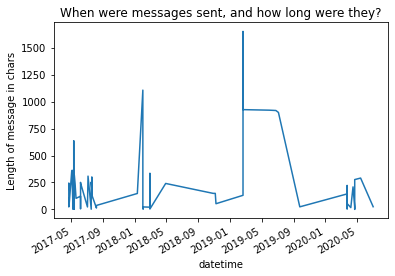

In [19]:
all_df.message_length.plot()
plt.title("When were messages sent, and how long were they?")
plt.ylabel("Length of message in chars")

In [12]:
all_df.displayName.value_counts()

Charles Ogilvie    52
mahender           10
Skype               8
John Doherty        2
nicksayes           1
michael..wu         1
Bianca Toth         1
Lauren Foley        1
Suleiman Hadidi     1
Robert Woodbury     1
Name: displayName, dtype: int64

In [28]:
all_df.machine_message.value_counts()


True     77
False    53
Name: machine_message, dtype: int64

In [32]:
all_df[all_df.machine_message==False][["from", "content"]]

,from,content
datetime,,
2019-09-24 15:01:49.150000+00:00,8:mahenderverma,"Hello Ben, How are you ?"
2018-02-26 22:03:07.216000+00:00,8:notionparallax,Cool
2018-02-26 22:02:27.288000+00:00,8:mahenderverma,"As usual doing projects for others, have done ..."
2018-02-26 21:43:51.612000+00:00,8:notionparallax,How about you?
2018-02-26 21:43:44.477000+00:00,8:notionparallax,“The Shakedown: Experimentally deriving the ru...
2018-02-26 21:43:23.363000+00:00,8:mahenderverma,"Thats nice <ss type=""smile"">:)</ss>"
2018-02-26 21:43:10.430000+00:00,8:notionparallax,We just wrote one up actually
2018-02-26 21:41:15.375000+00:00,8:mahenderverma,So what projects going on your side ?
2018-02-26 21:25:16.335000+00:00,8:mahenderverma,I am good.


In [23]:
all_df.loc[all_df.message_length.idxmax()].content

'<URIObject type="SWIFT.1" url_thumbnail="https://urlp.asm.skype.com/v1/url/content?url=https://static-asm.secure.skypeassets.com/pes/v1/emoticons/learn/views/default_180"><a href="https://go.skype.com/download?WT.mc_id=ICCO_2488_card_fallback">https://go.skype.com/download?WT.mc_id=ICCO_2488_card_fallback</a><Title>Sent you a card!</Title><Swift b64="ew0KICAidHlwZSI6ICJtZXNzYWdlL2NhcmQiLA0KICAic3VtbWFyeSI6ICJGYW1pbHkgY2hhdCIsDQogICJhdHRhY2htZW50cyI6IFsNCiAgICB7DQogICAgICAiY29udGVudFR5cGUiOiAiYXBwbGljYXRpb24vdm5kLm1pY3Jvc29mdC5jYXJkLmhlcm8iLA0KICAgICAgImNvbnRlbnQiOiB7DQogICAgICAgICJ0aXRsZSI6ICJDb25uZWN0IHdpdGggeW91ciBmYW1pbHkgYW55d2hlcmUiLA0KICAgICAgICAidGV4dCI6ICJZb3VyIGZhbWlseVx1MDAyN3MgZ3JvdXAgY2hhdCBpcyByZWFkeS4gU2VuZCBhbiBpbnN0YW50IG1lc3NhZ2Ugb3IganVtcCBvbiBhIGdyb3VwIHZpZGVvIGNhbGwuIiwNCiAgICAgICAgImltYWdlcyI6IFsNCiAgICAgICAgICB7DQogICAgICAgICAgICAidHlwZSI6ICJzaG93SW1hZ2UiLA0KICAgICAgICAgICAgInVybCI6ICJodHRwczovL2F6NzA1MTgzLnZvLm1zZWNuZC5uZXQvZGFtL3NreXBlL21lZGlhL2NvbmNpZXJnZS1hc3